# 1. Imports

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import io
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow import keras
from tensorflow.keras import layers
from scipy.io import loadmat
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from azureml.core import Dataset, Run, Workspace
from imutils import paths

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


# 2. Setup constants

In [2]:
path_names = {
        'DATA_PATH': os.path.join('data'),
        'MODEL_PATH': os.path.join('models'),
        'LOG_PATH': os.path.join('logs'),
        'TEST_PATH': os.path.join('test')
}

batch_size = 64
img_height = 224
img_width = 224

# 3. Download dataset

In [ ]:
run = Run.get_context()
ws = Workspace.from_config()

dataset_name = 'Smoking'

dataset = Dataset.get_by_name(workspace=ws, name=dataset_name)
dataset.download(path_names['DATA_PATH'])

# 4. Prepare labels and data

In [3]:
data = []
labels = []
imagePaths = list(paths.list_images(path_names['DATA_PATH']))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# 5. Load dataset

In [4]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# 6. Build model

In [5]:
backbone = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
backbone.trainable = False

input_layer = layers.Input((img_width, img_height, 3))

embedding = backbone(input_layer, training=False)
embedding = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(embedding)
embedding = tf.keras.layers.Flatten(name="flatten")(embedding)
embedding = tf.keras.layers.Dense(128, activation="relu")(embedding)
embedding = tf.keras.layers.Dropout(0.5)(embedding)
embedding = tf.keras.layers.Dense(2, activation="softmax")(embedding)

model = tf.keras.Model(inputs=[input_layer], outputs=[embedding])

opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258   

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# 7. Train only top layers

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    mode="min",
    restore_best_weights=True,
)
log_dir = os.path.join(path_names['LOG_PATH'], datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), epochs=1000, 
                    callbacks=[early_stopping, tensorboard_callback],
                    steps_per_epoch=len(trainX) // batch_size, validation_data=(testX, testY), 
                    validation_steps=len(testX) // batch_size)

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/1000
65/65 [==============================] - 95s 1s/step - loss: 0.7206 - accuracy: 0.6438 - val_loss: 0.5363 - val_accuracy: 0.7312
Epoch 2/1000
65/65 [==============================] - 76s 1s/step - loss: 0.5665 - accuracy: 0.7265 - val_loss: 0.4651 - val_accuracy: 0.7987
Epoch 3/1000
65/65 [==============================] - 76s 1s/step - loss: 0.5223 - accuracy: 0.7589 - val_loss: 0.4265 - val_accuracy: 0.8281
Epoch 4/1000
65/65 [==============================] - 76s 1s/step - loss: 0.4731 - accuracy: 0.7803 - val_loss: 0.3980 - val_accuracy: 0.8376
Epoch 5/1000
65/65 [==============================] - 76s 1s/step - loss: 0.4638 - accuracy: 0.7950 - val_loss: 0.3820 - val_accuracy: 0.8471
Epoch 6/1000
65/65 [==============================] - 76s 1s/step - loss: 0.4433 - accur

# 8. Unfreeze backbone

In [7]:
backbone.trainable = True

for layer in backbone.layers[:-110]:
    layer.trainable = False

model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258   

# 9. Train full model

In [8]:
history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), epochs=1000, 
                    callbacks=[early_stopping, tensorboard_callback],
                    steps_per_epoch=len(trainX) // batch_size, validation_data=(testX, testY), 
                    validation_steps=len(testX) // batch_size)

Epoch 1/1000
65/65 [==============================] - 122s 2s/step - loss: 0.7891 - accuracy: 0.5985 - val_loss: 0.5535 - val_accuracy: 0.7597
Epoch 2/1000
65/65 [==============================] - 101s 2s/step - loss: 0.4877 - accuracy: 0.7777 - val_loss: 0.3988 - val_accuracy: 0.8310
Epoch 3/1000
65/65 [==============================] - 102s 2s/step - loss: 0.4291 - accuracy: 0.8230 - val_loss: 0.4138 - val_accuracy: 0.8253
Epoch 4/1000
65/65 [==============================] - 102s 2s/step - loss: 0.3900 - accuracy: 0.8343 - val_loss: 0.3134 - val_accuracy: 0.8680
Epoch 5/1000
65/65 [==============================] - 102s 2s/step - loss: 0.3378 - accuracy: 0.8580 - val_loss: 0.2998 - val_accuracy: 0.8746
Epoch 6/1000
65/65 [==============================] - 102s 2s/step - loss: 0.3107 - accu

# 10. Save model

In [10]:
model.save(os.path.join(path_names['MODEL_PATH'], 'smoking.h5'))

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# 11. Predict

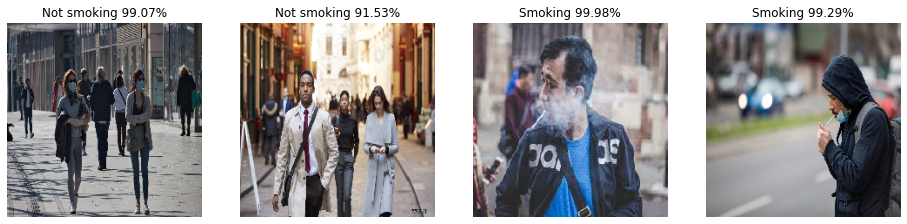

In [44]:
LABEL_MAP = {0:"Not smoking",
             1:"Smoking"}

fig,axes = plt.subplots(ncols=4,figsize=(4*4,4))

imagePaths = list(paths.list_images('test'))

for i in range(4):
    image = load_img(imagePaths[i], target_size=(224, 224))
    axes[i].imshow(image)
    axes[i].axis('off')
    image = img_to_array(image)
    image = preprocess_input(image)
    prediction = model.predict(np.expand_dims(image, 0))
    title = LABEL_MAP[0 if prediction[0][0] > 0.5 else 1]
    axes[i].set_title("{} {:0.2f}%".format(title, max(prediction[0]) * 100))